In [1]:
import imp
import numpy as np
from astropy import table
from astropy.table import Table
import pandas as pd
from itertools import combinations 
import matplotlib.pyplot as plt
from scipy import stats


import classes
imp.reload(classes)
from classes import fits_file

import functions
imp.reload(functions)
from functions import voronoi_binning_example

# Initialize the data

In [9]:
#define elements and properties for which uncertainties are to be calculated
elements=['C_FE','CI_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',\
          'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE',\
            'CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

properties=['TEFF','LOGG','M_H','ALPHA_M']


In [3]:
#read and initialize the allCal file which is used to calculate the uncertainties
allCal = fits_file("allCal-r12-l33.fits","default")
allCal.allCal_init("giants")

In [12]:
#read and initialize the file containing the stars for which the uncertainties are to be calculated
# cluster_members = fits_file('/uufs/astro.utah.edu/common/home/u1063369/Documents/allStar-r12-l33.fits')
cluster_members = fits_file("Cluster_members.fits", "Data_Files/")
cluster_members.cluster_members_init("giants")
cluster_members.uncertainties()

#quality cuts
giants=cluster_members.data
#membership probability condition and Teff range
giants = giants[np.logical_and.reduce((giants['no_sigmas_total'] < 3, giants['TEFF']>3600))]   
from astropy.table import unique
giants_unique = unique(giants,keys='APOGEE_ID')# remove duplicates
giants_unique = giants_unique[giants_unique['VSCATTER']<1]# remove potential binaries
giants_unique = giants_unique[giants_unique['LOGG']<3]# additional condition for giants
#bitmasks for quality cuts
giants_unique = giants_unique[np.logical_and.reduce((\
                    giants_unique['STARFLAG'] & 2**17 == 0, giants_unique['STARFLAG'] & 2**2 == 0,\
                    giants_unique['STARFLAG'] & 2**3 == 0, giants_unique['ASPCAPFLAG'] & 2**19 == 0,\
                    giants_unique['ASPCAPFLAG'] & 2**20 == 0, giants_unique['ASPCAPFLAG'] & 2**23 == 0))]
#SNR cut
giants_unique = giants_unique[giants_unique['SNR']>50]

/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


# Calculate the differences in parameter determinations between pairs of multiple visits


In [6]:
def calculate_differences(allCal):
    #list of duplicates in allCal file
    list_of_dups=np.unique(allCal.data['APOGEE_ID'],return_counts=True)[0]\
                 [np.unique(allCal.data['APOGEE_ID'],return_counts=True)[1]>1]
    #define dataframe for storing the abundance differences between pairs of duplicates in each element
    diffs_df=pd.DataFrame(columns=['APOGEE_ID','SNR','TEFF','MH'])
    for i,ap_id in enumerate(list_of_dups): #iterate throught the list of duplicates
        locs=np.where(allCal.data['APOGEE_ID']==ap_id)
        comb=combinations(locs[0],2) #break up the duplicates into pairs
        for j in list(comb):
            #check if the duplicates SNRs are within 20% of each other
            if np.logical_and.reduce((abs(allCal.data['SNR'][j[0]]-allCal.data['SNR'][j[1]])/\
                    max(allCal.data['SNR'][j[0]],allCal.data['SNR'][j[1]])<0.2\
            ,abs(allCal.data['FPARAM'][j[0]][0]-allCal.data['FPARAM'][j[1]][0])<100\
    #                 max(allCal['FPARAM'][j[0]][0],allCal['FPARAM'][j[1]][0])<0.2\
            ,abs(allCal.data['FPARAM'][j[0]][3]-allCal.data['FPARAM'][j[1]][3])<0.07)):
    #                 max(allCal['FPARAM'][j[0]][3],allCal['FPARAM'][j[1]][3])<0.2)):
                #get the temperature, snr, metallicity, and apogee id
                teff=allCal.data['FPARAM'][j[0],0]
                snr=allCal.data['SNR'][j[0]]
                mh=allCal.data['FPARAM'][j[0],3]
                apogee_id=allCal.data['APOGEE_ID'][j[0]]
                diffs=np.zeros(len(elements))
                vals=np.zeros(len(elements))
                for i in range(len(elements)):
                    #calculate the differences for all elements
                    diffs[i]=allCal.data['FELEM'][j[0],0,i]-allCal.data['FELEM'][j[1],0,i]
                    vals[i]=allCal.data['FELEM'][j[0],0,i]
                #calculate the differences for the parameters as well
                diffs_teff=allCal.data['FPARAM'][j[0],0]-allCal.data['FPARAM'][j[1],0]
                diffs_logg=allCal.data['FPARAM'][j[0],1]-allCal.data['FPARAM'][j[1],1]
                diffs_m_h=allCal.data['FPARAM'][j[0],3]-allCal.data['FPARAM'][j[1],3]
                diffs_alpha_m=allCal.data['FPARAM'][j[0],6]-allCal.data['FPARAM'][j[1],6]
                #save all the differences into a dataframe
                diffs_df=diffs_df.append({'TEFF':teff,'SNR':snr,'APOGEE_ID':apogee_id,'MH':mh,'C_FE_diff':diffs[0],\
                              'CI_FE_diff':diffs[1],'N_FE_diff':diffs[2],'O_FE_diff':diffs[3],'NA_FE_diff':diffs[4],\
                              'MG_FE_diff':diffs[5],'AL_FE_diff':diffs[6],'SI_FE_diff':diffs[7],'P_FE_diff':diffs[8],\
                              'S_FE_diff':diffs[9],'K_FE_diff':diffs[10],'CA_FE_diff':diffs[11],'TI_FE_diff':diffs[12],\
                              'TIII_FE_diff':diffs[13],'V_FE_diff':diffs[14],'CR_FE_diff':diffs[15],\
                              'MN_FE_diff':diffs[16],'FE_H_diff':diffs[17],'CO_FE_diff':diffs[18],\
                              'NI_FE_diff':diffs[19],'CU_FE_diff':diffs[20],'GE_FE_diff':diffs[21],\
                              'RB_FE_diff':diffs[22],'CE_FE_diff':diffs[23],'ND_FE_diff':diffs[24],\
                              'YB_FE_diff':diffs[25],'TEFF_diff':diffs_teff,'LOGG_diff':diffs_logg,\
                              'M_H_diff':diffs_m_h,'ALPHA_M_diff':diffs_alpha_m,\
                              'C_FE':diffs[0],\
                              'CI_FE':vals[1],'N_FE':vals[2],'O_FE':vals[3],'NA_FE':vals[4],\
                              'MG_FE':vals[5],'AL_FE':vals[6],'SI_FE':vals[7],'P_FE':vals[8],\
                              'S_FE':vals[9],'K_FE':vals[10],'CA_FE':vals[11],'TI_FE':vals[12],\
                              'TIII_FE':vals[13],'V_FE':vals[14],'CR_FE':vals[15],\
                              'MN_FE':vals[16],'FE_H':vals[17],'CO_FE':vals[18],\
                              'NI_FE':vals[19],'CU_FE':vals[20],'GE_FE':vals[21],\
                              'RB_FE':vals[22],'CE_FE':vals[23],'ND_FE':vals[24],\
                              'YB_FE':vals[25]},ignore_index=True)
    return diffs_df


In [7]:
#calculate and return the dataframe of differences in parameters between pairs of multiple visits
diffs_df_new = calculate_differences(allCal)          

In [8]:
#view the dataframe
diffs_df_new

APOGEE_ID         SNR         TEFF        MH  ALPHA_M_diff  \
0     2M00002012+5612368  379.990997  4703.200195  0.137960     -0.000095   
1     2M00002012+5612368  379.990997  4703.200195  0.137960     -0.018495   
2     2M00002012+5612368  334.790985  4674.399902  0.139010     -0.018400   
3     2M00020976+1601393  199.128998  4102.000000 -1.893000      0.003780   
4     2M00020976+1601393  199.128998  4102.000000 -1.893000      0.018890   
...                  ...         ...          ...       ...           ...   
8724  2M23581471+5651466  327.062988  4235.899902 -0.020325     -0.001520   
8725  2M23590825+1652528  155.878006  5193.200195 -0.842000     -0.009490   
8726  2M23591467+6205474  262.649994  3400.000000 -0.383510     -0.036724   
8727           HD_137443  231.048996  4242.600098  0.118600      0.028727   
8728            HD_32518   54.309898  4603.200195 -0.008611     -0.001166   

         AL_FE  AL_FE_diff     CA_FE  CA_FE_diff     CE_FE  ...  S_FE_diff  \
0     0.253040   -0.057750 -0.010229   -0.007413  0.254840  ...  -0.008922   
1     0.253040   -0.007740 -0.010229    0.009447  0.254840  ...  -0.001803   
2     0.310790    0.050010 -0.002816    0.016860  0.266070  ...   0.007119   
3    -2.107500    0.015500 -0.065210   -0.078376 -2.050500  ...  -0.151960   
4    -2.107500   -0.001500 -0.065210   -0.108839 -2.050500  ...  -0.005940   
...        ...         ...       ...         ...       ...  ...        ...   
8724  0.055617   -0.020513 -0.051570   -0.007387 -0.206150  ...   0.068980   
8725 -0.480480    0.009690  0.107370   -0.052360 -1.098600  ...  -0.158730   
8726 -0.514430   -0.062500  0.029719   -0.017841 -0.628300  ...   0.030873   
8727  0.261750   -0.013520 -0.028858    0.009268 -0.315320  ...   0.036626   
8728  0.090721   -0.024099 -0.039797   -0.019930  0.063264  ...  -0.076450   

      TEFF_diff   TIII_FE  TIII_FE_diff     TI_FE  TI_FE_diff      V_FE  \
0     28.800293  0.352490      0.185840  0.012308   -0.013208 -0.009113   
1      5.300293  0.352490      0.102290  0.012308   -0.004847 -0.009113   
2    -23.500000  0.166650     -0.083550  0.025516    0.008361 -0.138540   
3     -5.399902  0.492030      0.021290 -0.175330   -0.034150 -1.717400   
4      8.000000  0.492030      0.251980 -0.175330    0.005640 -1.717400   
...         ...       ...           ...       ...         ...       ...   
8724  -8.899902  0.280630      0.128130 -0.039194   -0.020891 -0.365010   
8725 -74.799805  0.499050     -0.287090  0.079288   -0.038792 -0.610300   
8726  25.100098  0.055126      0.070687 -0.003345   -0.002671 -0.505800   
8727   7.800293  0.200270      0.090190  0.039606   -0.007633 -0.095106   
8728 -14.299805  0.238170      0.165009  0.055259    0.034826 -0.170230   

      V_FE_diff     YB_FE  YB_FE_diff  
0      0.129427 -0.364820   -0.265394  
1      0.047614 -0.364820   -0.312720  
2     -0.081813 -0.099426   -0.047326  
3      0.172600 -1.593600   -0.161200  
4      0.185700 -1.593600    0.868300  
...         ...       ...         ...  
8724  -0.059320 -0.133040   -0.014310  
8725   0.169360 -1.489200    0.948600  
8726  -0.009330 -0.716430   -0.282810  
8727   0.136674  0.137090    0.005010  
8728   0.007870 -0.967890   -0.861750  

[8729 rows x 60 columns]

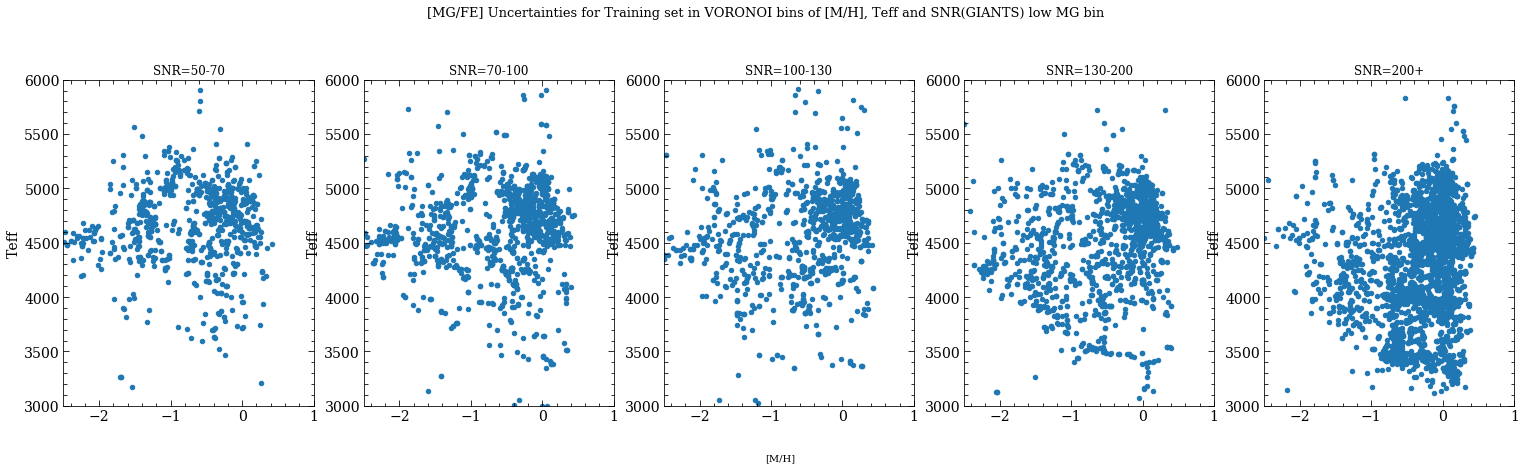

In [10]:
#visualize the training data in all bins
conditions_snr=[np.logical_and(diffs_df_new['SNR']>50,diffs_df_new['SNR']<70),\
                np.logical_and(diffs_df_new['SNR']>70,diffs_df_new['SNR']<100),\
            np.logical_and(diffs_df_new['SNR']>100,diffs_df_new['SNR']<130),\
            np.logical_and(diffs_df_new['SNR']>130,diffs_df_new['SNR']<200),\
            diffs_df_new['SNR']>200]
snr=['50-70','70-100','100-130','130-200','200+']

fig,ax=plt.subplots(nrows=1,ncols=len(conditions_snr),figsize=(26,len(conditions_snr)+1))
for j in range(len(conditions_snr)):
    condition=[diffs_df_new['SNR']==j]
    im=ax[j].scatter(diffs_df_new['MH'][conditions_snr[j]],diffs_df_new['TEFF'][conditions_snr[j]],s=20,\
                     #c=diffs_df_new['MG_FE_uncertainty'][conditions_snr[j]],\
                     edgecolor='face',vmin=0.015,vmax=0.08)# ax[0].set_xticks([-1.0,-0.5,0.0,0.5])
    ax[j].set_ylabel('Teff')
    ax[j].set_title('SNR='+str(snr[j]))
    ax[j].set_ylim([3000,6000])
    ax[j].set_xlim([-2.5,1.0])
fig.text(0.5,0.0,'[M/H]')
fig.suptitle('[MG/FE] Uncertainties for Training set in VORONOI bins of [M/H], Teff and SNR'
             '(GIANTS) low MG bin',x=0.5,y=1.05,fontsize=13)
# plt.savefig('Run 8 Uncertainties/MG_FE_uncertainties_for_training_set_in_VORONOI_bins_of_M_H_Teff_and_SNR_giants_'
#             'median_run_8_low_MG_FE_bin.png',dpi=300,bbox_inches='tight')
plt.show()

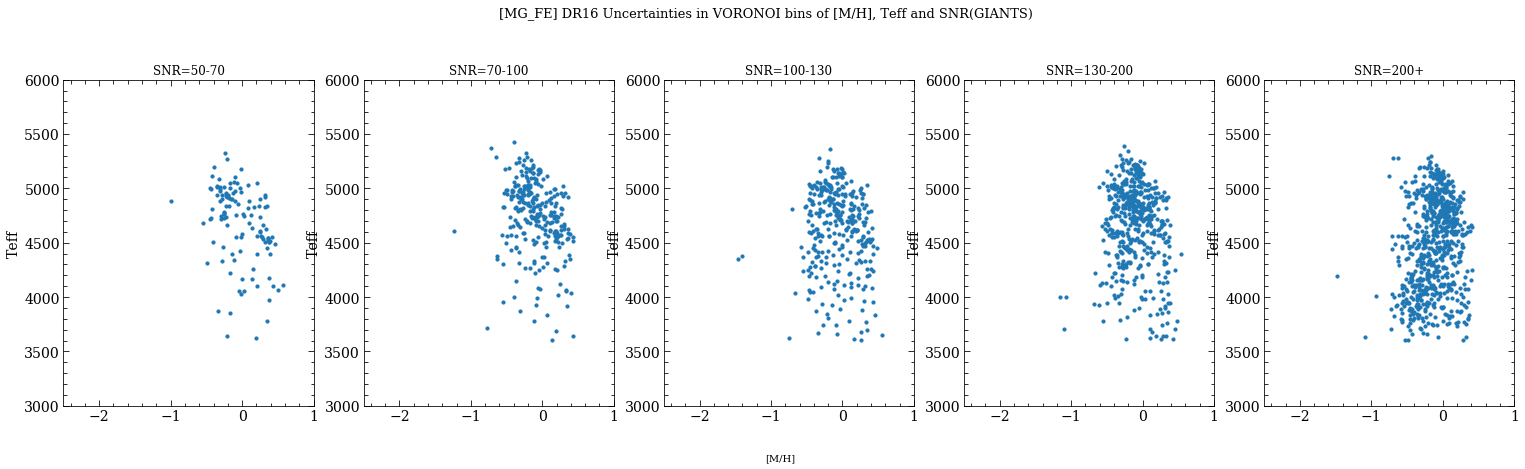

In [13]:
#visualize the test data in all bins
conditions_snr=[np.logical_and(giants_unique['SNR']>50, giants_unique['SNR']<70),\
                np.logical_and(giants_unique['SNR']>70,giants_unique['SNR']<100),\
            np.logical_and(giants_unique['SNR']>100,giants_unique['SNR']<130),\
            np.logical_and(giants_unique['SNR']>130,giants_unique['SNR']<200),\
            giants_unique['SNR']>200]
# condition_nan=np.array(condition_nan).reshape(-1)
snr=['50-70','70-100','100-130','130-200','200+']

for i in range(len(elements)):
    if elements[i] == 'MG_FE':
        fig,ax=plt.subplots(nrows=1,ncols=len(conditions_snr),figsize=(26,len(conditions_snr)+1))
        for j in range(len(conditions_snr)):
            im=ax[j].scatter(giants_unique['M_H'][conditions_snr[j]],\
                             giants_unique['TEFF'][conditions_snr[j]],s=10,\
                             edgecolor='face',vmin=0.015,vmax=0.055)# ax[0].set_xticks([-1.0,-0.5,0.0,0.5])
            ax[j].set_ylabel('Teff')
            ax[j].set_title('SNR='+str(snr[j]))
            ax[j].set_ylim([3000,6000])
            ax[j].set_xlim([-2.5,1.0])
        fig.text(0.5,0.0,'[M/H]')
        fig.suptitle('['+elements[i]+'] DR16 Uncertainties in VORONOI bins of [M/H], Teff and SNR'
                     '(GIANTS)',x=0.5,y=1.05,fontsize=13)
#         plt.savefig('Run 8 Uncertainties/'+elements[i]+
#                     '_DR_16_uncertainties_for__in_VORONOI_bins_of_M_H_Teff_and_SNR_giants_'
#                     'median_run_8_scaled.png',dpi=300,bbox_inches='tight')
        plt.show()


In [14]:
no_pairs=np.array([1.0]*len(diffs_df_new))
noise_no_pairs=np.array([1.0]*len(diffs_df_new))


In [20]:
diffs_df_new['TEFF_MH_bin'] = np.nan
#define dataframe for uncertainties along with the bin numbers in Teff-[M/H] and SNR space 
uncerts_in_bins=pd.DataFrame([],columns=['TEFF_MH_bin','SNR_bin','Num_pairs','C_FE_uncertainty',\
                                         'CI_FE_uncertainty','N_FE_uncertainty','O_FE_uncertainty',\
                                         'NA_FE_uncertainty','MG_FE_uncertainty','AL_FE_uncertainty',\
                                         'SI_FE_uncertainty','P_FE_uncertainty','S_FE_uncertainty',\
                                         'K_FE_uncertainty','CA_FE_uncertainty','TI_FE_uncertainty',\
                                         'TIII_FE_uncertainty','V_FE_uncertainty','CR_FE_uncertainty',\
                                         'MN_FE_uncertainty','FE_H_uncertainty','CO_FE_uncertainty',\
                                         'NI_FE_uncertainty','CU_FE_uncertainty','GE_FE_uncertainty',\
                                         'RB_FE_uncertainty','CE_FE_uncertainty','ND_FE_uncertainty',\
                                         'YB_FE_uncertainty','TEFF_uncertainty','LOGG_uncertainty',\
                                         'M_H_uncertainty','ALPHA_M_uncertainty'])
#initialize uncertainties
for this_element in elements:
    diffs_df_new[this_element+"_uncertainty"]=np.nan

#the bin limits in SNR determined from trial and error to have at least 15 stars in each bin.
conditions_snr_diffs=[np.logical_and(diffs_df_new['SNR']>50,diffs_df_new['SNR']<70),\
                np.logical_and(diffs_df_new['SNR']>70,diffs_df_new['SNR']<100),\
            np.logical_and(diffs_df_new['SNR']>100,diffs_df_new['SNR']<130),\
            np.logical_and(diffs_df_new['SNR']>130,diffs_df_new['SNR']<200),\
            diffs_df_new['SNR']>200]
#similar bins for cluster members
conditions_snr_cluster=[np.logical_and(cluster_members.data['SNR']>50,cluster_members.data['SNR']<70),\
                        np.logical_and(cluster_members.data['SNR']>70,cluster_members.data['SNR']<100),\
                        np.logical_and(cluster_members.data['SNR']>100,cluster_members.data['SNR']<130),\
            np.logical_and(cluster_members.data['SNR']>130,cluster_members.data['SNR']<200),\
            cluster_members.data['SNR']>200]

#nan condition
condition_nan=[~np.isnan(diffs_df_new['MG_FE_diff'])]
condition_nan=np.array(condition_nan).reshape(-1)
snr=['50-70','70-100','100-130','130-200','200+']

#for plotting
# fig,ax=plt2.subplots(nrows=2,ncols=len(conditions_snr_cluster),figsize=(22,9))
#assign uncertainties for all elements into bins of Teff-M_H and SNR  
#targetSN=[25,60,60,150] #for red_giants
targetSN=[30,30,30,30,30]#targetted number of stars in each [M/H]-Teff bin
#Voronoi binning in [M/H]-Teff space
for j in range(len(conditions_snr_diffs)):# iterate over each SNR bin
    uncerts_in_bins=pd.DataFrame([],columns=['TEFF_MH_bin','SNR_bin','Num_pairs','C_FE_uncertainty',\
                                         'CI_FE_uncertainty','N_FE_uncertainty','O_FE_uncertainty',\
                                         'NA_FE_uncertainty','MG_FE_uncertainty','AL_FE_uncertainty',\
                                         'SI_FE_uncertainty','P_FE_uncertainty','S_FE_uncertainty',\
                                         'K_FE_uncertainty','CA_FE_uncertainty','TI_FE_uncertainty',\
                                         'TIII_FE_uncertainty','V_FE_uncertainty','CR_FE_uncertainty',\
                                         'MN_FE_uncertainty','FE_H_uncertainty','CO_FE_uncertainty',\
                                         'NI_FE_uncertainty','CU_FE_uncertainty','GE_FE_uncertainty',\
                                         'RB_FE_uncertainty','CE_FE_uncertainty','ND_FE_uncertainty',\
                                         'YB_FE_uncertainty','TEFF_uncertainty','LOGG_uncertainty',\
                                         'M_H_uncertainty','ALPHA_M_uncertainty',\
                                         'C_FE_uncertainty_failure_rate','CI_FE_uncertainty_failure_rate',\
                                         'N_FE_uncertainty_failure_rate','O_FE_uncertainty_failure_rate',\
                                         'NA_FE_uncertainty_failure_rate','MG_FE_uncertainty_failure_rate',\
                                         'AL_FE_uncertainty_failure_rate','SI_FE_uncertainty_failure_rate',\
                                         'P_FE_uncertainty_failure_rate','S_FE_uncertainty_failure_rate',\
                                         'K_FE_uncertainty_failure_rate','CA_FE_uncertainty_failure_rate',\
                                         'TI_FE_uncertainty_failure_rate','TIII_FE_uncertainty_failure_rate',\
                                         'V_FE_uncertainty_failure_rate','CR_FE_uncertainty_failure_rate',\
                                         'MN_FE_uncertainty_failure_rate','FE_H_uncertainty_failure_rate',\
                                         'CO_FE_uncertainty_failure_rate','NI_FE_uncertainty_failure_rate',\
                                         'CU_FE_uncertainty_failure_rate','GE_FE_uncertainty_failure_rate',\
                                         'RB_FE_uncertainty_failure_rate','CE_FE_uncertainty_failure_rate',\
                                         'ND_FE_uncertainty_failure_rate','YB_FE_uncertainty_failure_rate',\
                                         'TEFF_uncertainty_failure_rate','LOGG_uncertainty_failure_rate',\
                                         'M_H_uncertainty_failure_rate','ALPHA_M_uncertainty_failure_rate'])
    #select the SNR bin
    this_df_new=diffs_df_new[np.logical_and(conditions_snr_diffs[j],condition_nan)]
    #voronoi binning in [M/H]-Teff space
    if __name__ == '__main__':
        binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale=voronoi_binning_example(this_df_new,targetSN[j])

    #add the Teff_M_H bin no. to the differences file
    diffs_df_new['TEFF_MH_bin'][np.logical_and(conditions_snr_diffs[j],condition_nan)] = binNum
    
    #de-whiten the data
    xNode=xNode*np.std(this_df_new['MH'].values)+np.mean(this_df_new['MH'].values)
    yNode=yNode*np.std(this_df_new['TEFF'].values)+np.mean(this_df_new['TEFF'].values)

    #calculate the uncertainties for each Voronoi bin
    count=0
    for i in range(max(binNum)+1):
        num_pairs=len(this_df_new[binNum==i]['MG_FE_diff'])
        uncerts_in_bins=uncerts_in_bins.append({'TEFF_MH_bin':int(i),'SNR_bin':int(j),'Num_pairs':num_pairs},\
                                               ignore_index=True)

        for this_element in elements:
            #uncertainties
            uncert=np.median(np.abs(this_df_new[binNum==i][this_element+'_diff']))\
                *np.sqrt(np.pi)/2
            #no. of outliers
            num_outliers = np.sum(np.abs(np.median(np.abs(this_df_new[binNum==i][this_element+'_diff'])) -\
                            np.abs(this_df_new[binNum==i][this_element+'_diff'])) > \
                            2*np.std(this_df_new[binNum==i][this_element+'_diff']))#st.median_absolute_deviation(this_df_new[binNum==i][this_element+'_diff']))
            #fraction of outliers
            frac_outliers = num_outliers / len(this_df_new[binNum==i][this_element+'_diff'])
            #ks test to Normal distribution
            ks_test_D, ks_test_p = stats.kstest(this_df_new[binNum==i][this_element+'_diff'], 'norm')[:]
            #save uncertainites
            uncerts_in_bins.loc[count][this_element+'_uncertainty']=uncert     
            uncerts_in_bins.loc[count][this_element+'_uncertainty_failure_rate']=ks_test_p 
        
            this_df_new[this_element+'_uncertainty'][binNum==i] = \
                    uncerts_in_bins.loc[count][this_element+'_uncertainty']

        #STELLAR PARAMETERS
        for this_property in properties:

            uncert=np.median(np.abs(this_df_new[binNum==i][this_property+'_diff']))\
                        *np.sqrt(np.pi)/2
            uncerts_in_bins.loc[count][this_property+'_uncertainty']=uncert

        count+=1
        
    for this_element in elements:
        diffs_df_new[this_element+'_uncertainty'][np.logical_and(conditions_snr_diffs[j],condition_nan)] = \
                                            this_df_new[this_element+'_uncertainty']

    #assigning cluster members into these Voronoi bins 
    from sklearn.naive_bayes import GaussianNB# classification algorithm
    X=this_df_new[['MH','TEFF']].values
    y=binNum
    model=GaussianNB()
    model.fit(X,y)# training classifier

    #extract the M_H and Teff from cluster memebrs catalog
    this_merged=cluster_members.data[conditions_snr_cluster[j]]
    a=np.zeros([len(this_merged),2])
    for l in range(len(this_merged)):
        a[l,0]=this_merged['M_H'][l]
        a[l,1]=this_merged['TEFF'][l]

    #make sure there are no insane values!
    a=a[np.logical_and(a[:,0]>-1000,a[:,1]>-1000)]

    #predict the classes for the cluster members
    y_pred=model.predict(a)
    y_pred_prob=model.predict_proba(a)

#uncertainties for cluster members
    #assign stars in each SNR range into the corresponding bin
    cluster_members.data['TEFF_MH_bin'][conditions_snr_cluster[j]]=y_pred
    cluster_members.data['SNR_bin'][conditions_snr_cluster[j]]=j

#weighted average of the uncertainties with probability of classification across all Voronoi bins
    CC = np.zeros([len(elements)+len(properties),len(cluster_members.data[conditions_snr_cluster[j]])])
    CC_f = np.zeros([len(elements)+len(properties),len(cluster_members.data[conditions_snr_cluster[j]])])
    ks_test_D = np.zeros([len(elements)+len(properties),len(cluster_members.data[conditions_snr_cluster[j]])])
    ks_test_p = np.zeros([len(elements)+len(properties),len(cluster_members.data[conditions_snr_cluster[j]])])

    for k in range(len(cluster_members.data[conditions_snr_cluster[j]])):
        for l in range(len(elements)):
            CC[l,k] = np.sum(uncerts_in_bins[elements[l]+'_uncertainty']*y_pred_prob[k])#weighted average
        for this_prop in properties:
            CC[l,k]=np.sum(uncerts_in_bins[this_prop+'_uncertainty']*y_pred_prob[k])
            l+=1


    for k in range(len(cluster_members.data[conditions_snr_cluster[j]])):
        for l in range(len(elements)):
            CC_f[l,k] = uncerts_in_bins[elements[l]+'_uncertainty_failure_rate'][y_pred[k]]#failure rate
        for this_prop in properties:
            CC_f[l,k]=uncerts_in_bins[this_prop+'_uncertainty_failure_rate'][y_pred[k]]
            l+=1

    #save the uncertainties
    for l in range(len(elements)):
        cluster_members.data[elements[l]+'_uncertainty_derived'][conditions_snr_cluster[j]]=CC[l]
        cluster_members.data[elements[l]+'_uncertainty_failure_rate'][conditions_snr_cluster[j]] = CC_f[l]

    for l in range(len(properties)):
        cluster_members.data[properties[l]+'_uncertainty_derived'][conditions_snr_cluster[j]]=CC[l]
        cluster_members.data[properties[l]+'_uncertainty_failure_rate'][conditions_snr_cluster[j]] = CC_f[l]


Bin-accretion...
1  /  0
2  /  0
3  /  0
4  /  0
5  /  0
6  /  0
7  /  0
8  /  0
9  /  0
10  /  0
11  /  0
12  /  0
13  /  0
14  /  0
15  /  0
16  /  0
17  /  0
18  /  0
19  /  0
20  /  0
21  /  0
22  /  0
23  /  0
24  /  0
25  /  0
26  /  0
27  /  0
28  /  0
29  /  0
30  /  0
31  /  0
32  /  0
33  /  0
34  /  0
35  /  0
36  /  0
37  /  0
38  /  0
39  /  0
40  /  0
41  /  0
42  /  0
43  /  0
44  /  0
45  /  0
46  /  0
47  /  0
48  /  0
49  /  0
50  /  0
51  /  0
52  /  0
53  /  0
54  /  0
55  /  0
56  /  0
57  /  0
58  /  0
59  /  0
60  /  0
61  /  0
62  /  0
63  /  0
64  /  0
65  /  0
66  /  0
67  /  0
68  /  0
69  /  0
50  initial bins.
Reassign bad bins...
21  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 2.177
Iter:    2  Diff: 1.702
Iter:    3  Diff: 2.244
Iter:    4  Diff: 2.689
Iter:    5  Diff: 1.402
Iter:    6  Diff: 1.01
Iter:    7  Diff: 1.017
Iter:    8  Diff: 0.7714
Iter:    9  Diff: 0.5496
Iter:   10  Diff: 0.7951
Iter:   11  Diff: 0.4869
Iter:   12  Diff: 0.37

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

Bin-accretion...
1  /  1
2  /  1
3  /  1
4  /  1
5  /  1
6  /  1
7  /  1
8  /  1
9  /  1
10  /  1
11  /  1
12  /  1
13  /  1
14  /  1
15  /  1
16  /  1
17  /  1
18  /  1
19  /  1
20  /  1
21  /  1
22  /  1
23  /  1
24  /  1
25  /  1
26  /  1
27  /  1
28  /  1
29  /  1
30  /  1
31  /  1
32  /  1
33  /  1
34  /  1
35  /  1
36  /  1
37  /  1
38  /  1
39  /  1
40  /  1
41  /  1
42  /  1
43  /  1
44  /  1
45  /  1
46  /  1
47  /  1
48  /  1
49  /  1
50  /  1
51  /  1
52  /  1
53  /  1
54  /  1
55  /  1
56  /  1
57  /  1
58  /  1
59  /  1
60  /  1
61  /  1
62  /  1
63  /  1
64  /  1
65  /  1
66  /  1
67  /  1
68  /  1
69  /  1
70  /  1
71  /  1
72  /  1
73  /  1
74  /  1
75  /  1
76  /  1
77  /  1
78  /  1
79  /  1
80  /  1
81  /  1
82  /  1
83  /  1
84  /  1
85  /  1
86  /  1
69  initial bins.
Reassign bad bins...
35  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 3.296
Iter:    2  Diff: 2.64
Iter:    3  Diff: 2.371
Iter:    4  Diff: 1.485
Iter:    5  Diff: 2.184
Iter:    6  Diff:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

Bin-accretion...
1  /  1
2  /  1
3  /  1
4  /  1
5  /  1
6  /  1
7  /  1
8  /  1
9  /  1
10  /  1
11  /  1
12  /  1
13  /  1
14  /  1
15  /  1
16  /  1
17  /  1
18  /  1
19  /  1
20  /  1
21  /  1
22  /  1
23  /  1
24  /  1
25  /  1
26  /  1
27  /  1
28  /  1
29  /  1
30  /  1
31  /  1
32  /  1
33  /  1
34  /  1
35  /  1
36  /  1
37  /  1
38  /  1
39  /  1
40  /  1
41  /  1
42  /  1
43  /  1
44  /  1
45  /  1
46  /  1
47  /  1
48  /  1
49  /  1
50  /  1
51  /  1
52  /  1
53  /  1
54  /  1
55  /  1
56  /  1
57  /  1
58  /  1
59  /  1
60  /  1
61  /  1
62  /  1
63  /  1
64  /  1
65  /  1
66  /  1
67  /  1
68  /  1
69  /  1
70  /  1
71  /  1
72  /  1
73  /  1
42  initial bins.
Reassign bad bins...
26  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 3.659
Iter:    2  Diff: 2.404
Iter:    3  Diff: 1.556
Iter:    4  Diff: 1.792
Iter:    5  Diff: 0.8712
Iter:    6  Diff: 0.5306
Iter:    7  Diff: 0.6536
Iter:    8  Diff: 0.3403
Iter:    9  Diff: 0.3835
Iter:   10  Diff: 0.3679
Iter:  

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

Bin-accretion...
1  /  1
2  /  1
3  /  1
4  /  1
5  /  1
6  /  1
7  /  1
8  /  1
9  /  1
10  /  1
11  /  1
12  /  1
13  /  1
14  /  1
15  /  1
16  /  1
17  /  1
18  /  1
19  /  1
20  /  1
21  /  1
22  /  1
23  /  1
24  /  1
25  /  1
26  /  1
27  /  1
28  /  1
29  /  1
30  /  1
31  /  1
32  /  1
33  /  1
34  /  1
35  /  1
36  /  1
37  /  1
38  /  1
39  /  1
40  /  1
41  /  1
42  /  1
43  /  1
44  /  1
45  /  1
46  /  1
47  /  1
48  /  1
49  /  1
50  /  1
51  /  1
52  /  1
53  /  1
54  /  1
55  /  1
56  /  1
57  /  1
58  /  1
59  /  1
60  /  1
61  /  1
62  /  1
63  /  1
64  /  1
65  /  1
66  /  1
67  /  1
68  /  1
69  /  1
70  /  1
71  /  1
72  /  1
73  /  1
70  initial bins.
Reassign bad bins...
46  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 1.663
Iter:    2  Diff: 1.618
Iter:    3  Diff: 1.125
Iter:    4  Diff: 0.9047
Iter:    5  Diff: 0.8291
Iter:    6  Diff: 0.6898
Iter:    7  Diff: 0.5763
Iter:    8  Diff: 0.47
Iter:    9  Diff: 0.2627
Iter:   10  Diff: 0.4258
Iter:   

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

Bin-accretion...
1  /  3
2  /  3
3  /  3
4  /  3
5  /  3
6  /  3
7  /  3
8  /  3
9  /  3
10  /  3
11  /  3
12  /  3
13  /  3
14  /  3
15  /  3
16  /  3
17  /  3
18  /  3
19  /  3
20  /  3
21  /  3
22  /  3
23  /  3
24  /  3
25  /  3
26  /  3
27  /  3
28  /  3
29  /  3
30  /  3
31  /  3
32  /  3
33  /  3
34  /  3
35  /  3
36  /  3
37  /  3
38  /  3
39  /  3
40  /  3
41  /  3
42  /  3
43  /  3
44  /  3
45  /  3
46  /  3
47  /  3
48  /  3
49  /  3
50  /  3
51  /  3
52  /  3
53  /  3
54  /  3
55  /  3
56  /  3
57  /  3
58  /  3
59  /  3
60  /  3
61  /  3
62  /  3
63  /  3
64  /  3
65  /  3
66  /  3
67  /  3
68  /  3
69  /  3
70  /  3
71  /  3
72  /  3
73  /  3
74  /  3
75  /  3
76  /  3
77  /  3
78  /  3
79  /  3
80  /  3
81  /  3
82  /  3
83  /  3
84  /  3
85  /  3
86  /  3
87  /  3
88  /  3
89  /  3
90  /  3
91  /  3
92  /  3
93  /  3
94  /  3
95  /  3
96  /  3
97  /  3
98  /  3
99  /  3
100  /  3
101  /  3
102  /  3
103  /  3
104  /  3
105  /  3
106  /  3
107  /  3
108  /  3
109  /  3
1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

In [21]:
#additional SNR condition
cluster_members.data = cluster_members.data[cluster_members.data['SNR']>50]

(array([ 4577., 10356.,  5496.,  2105.,   523.,   182.,   151.,    15.,
           17.,    63.]),
 array([0.00940467, 0.01880349, 0.0282023 , 0.03760112, 0.04699993,
        0.05639875, 0.06579756, 0.07519638, 0.08459519, 0.093994  ,
        0.10339282]),
 <a list of 10 Patch objects>)

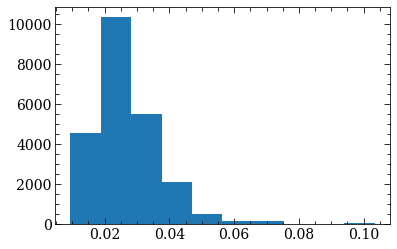

In [23]:
#histogram of derived uncertainties
plt.hist(cluster_members.data['AL_FE_uncertainty_derived'])

# Visualize rederived uncertianties in bins

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


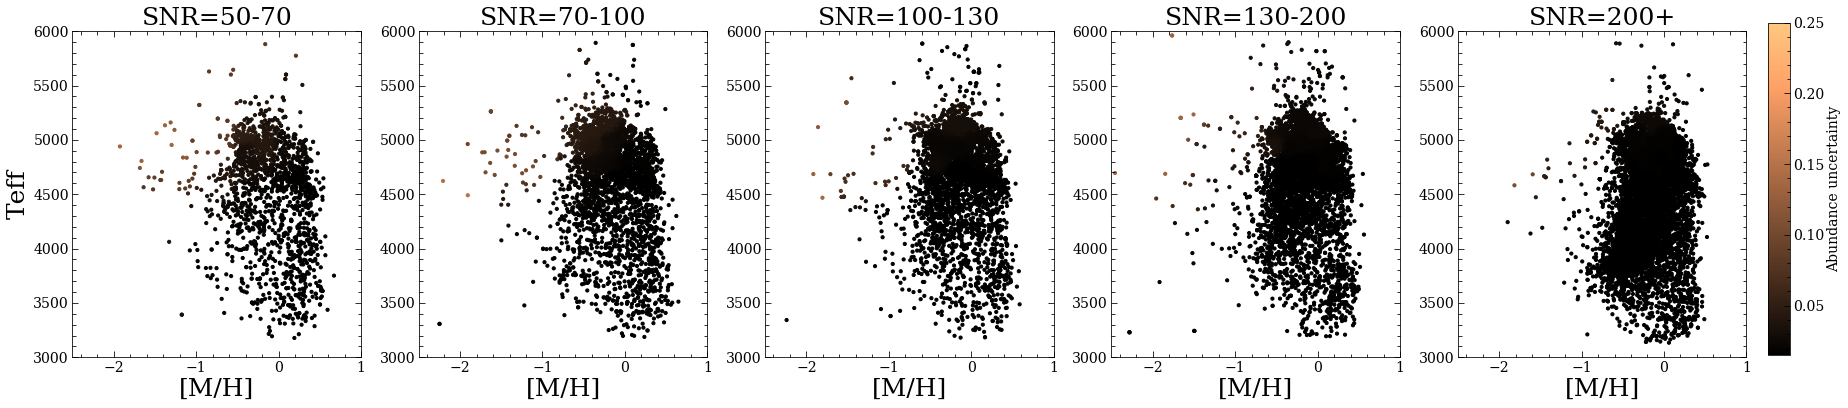

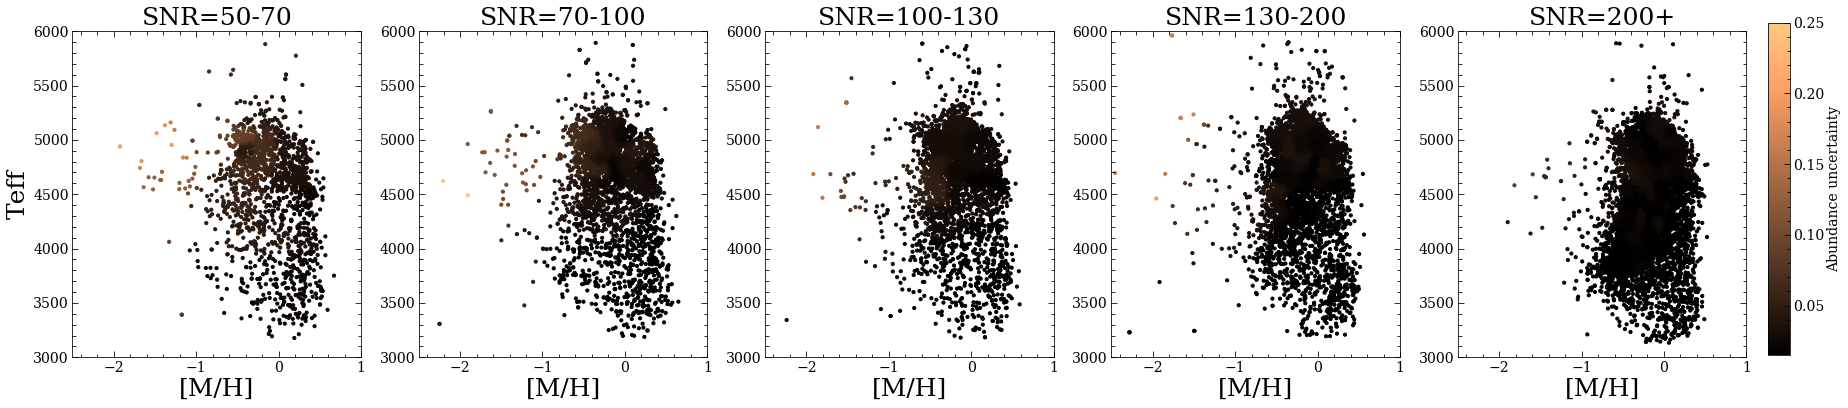

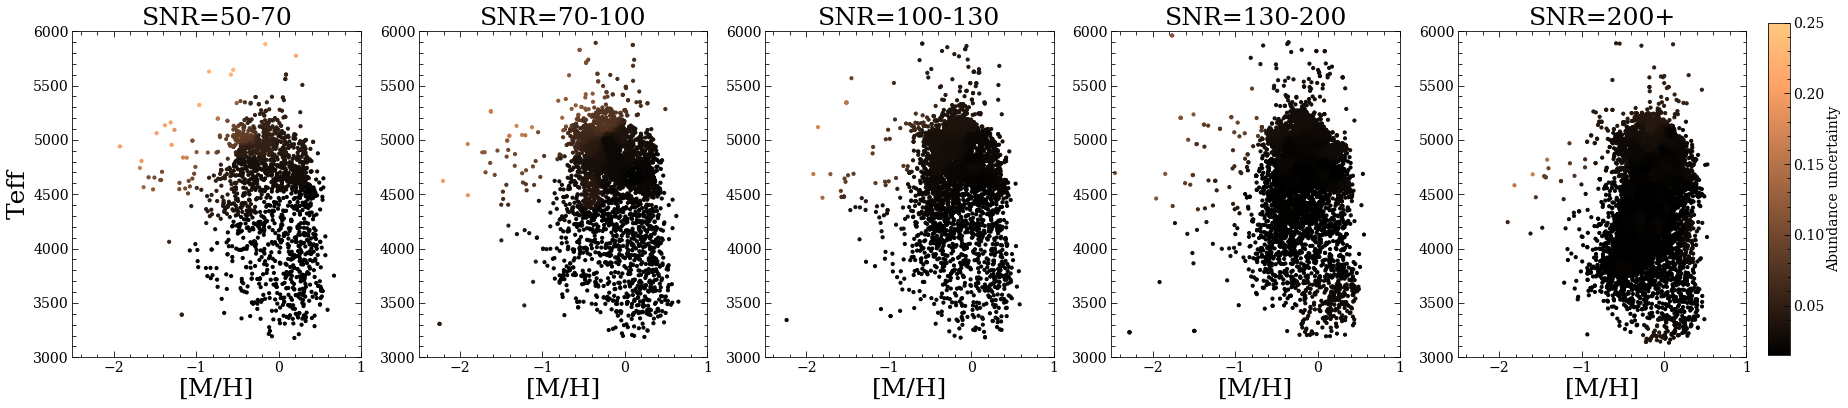

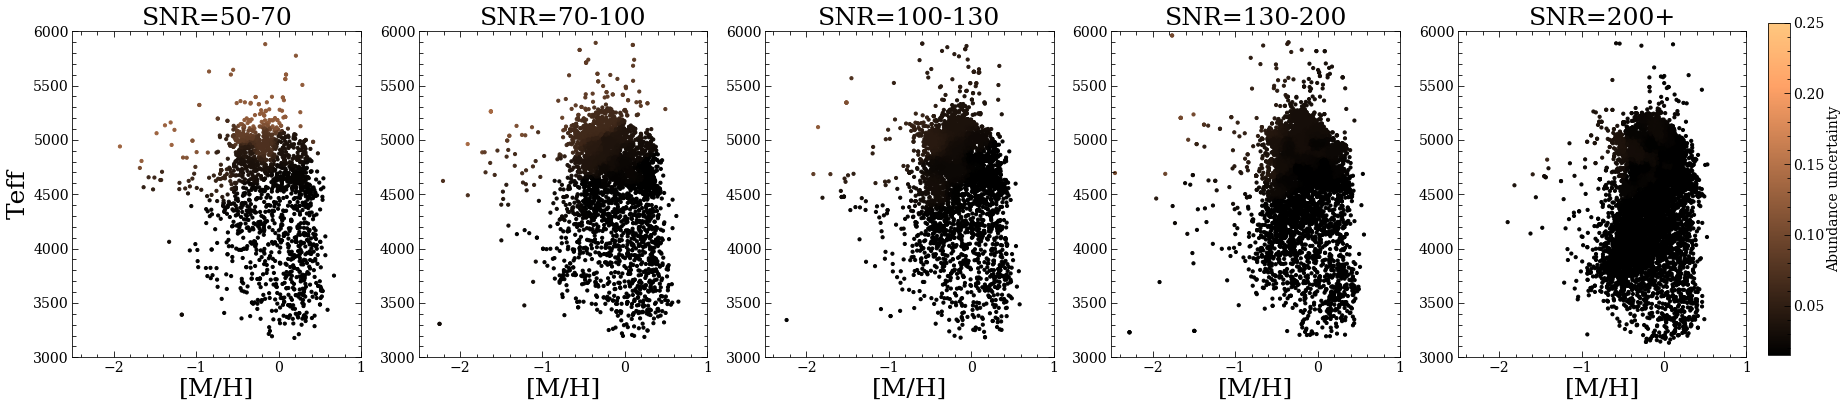

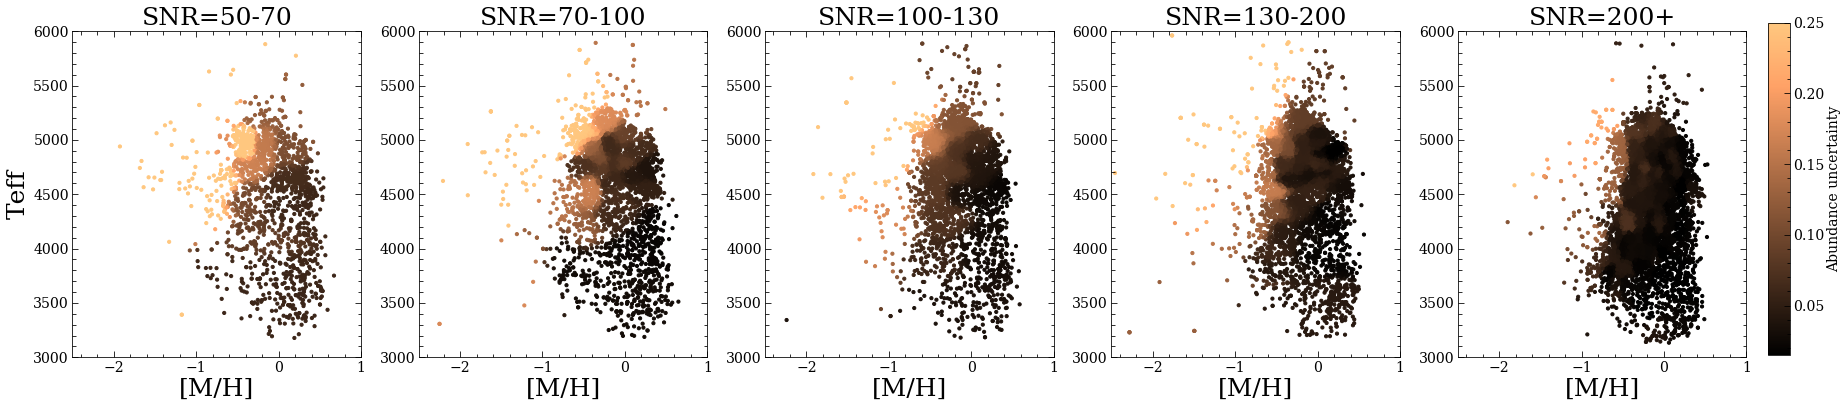

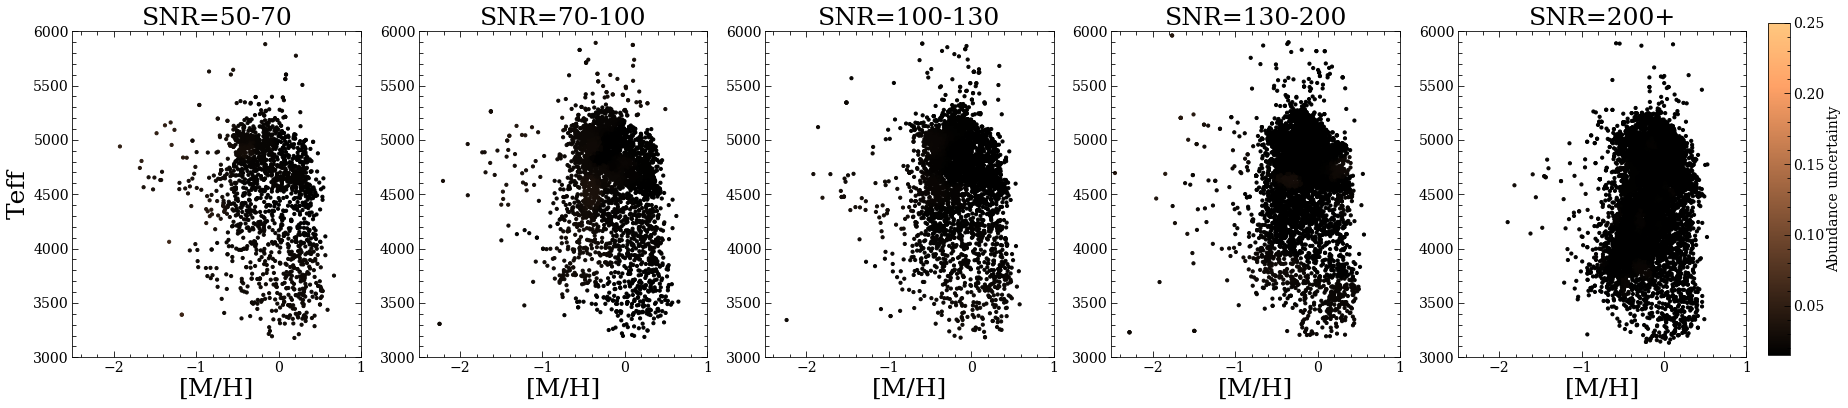

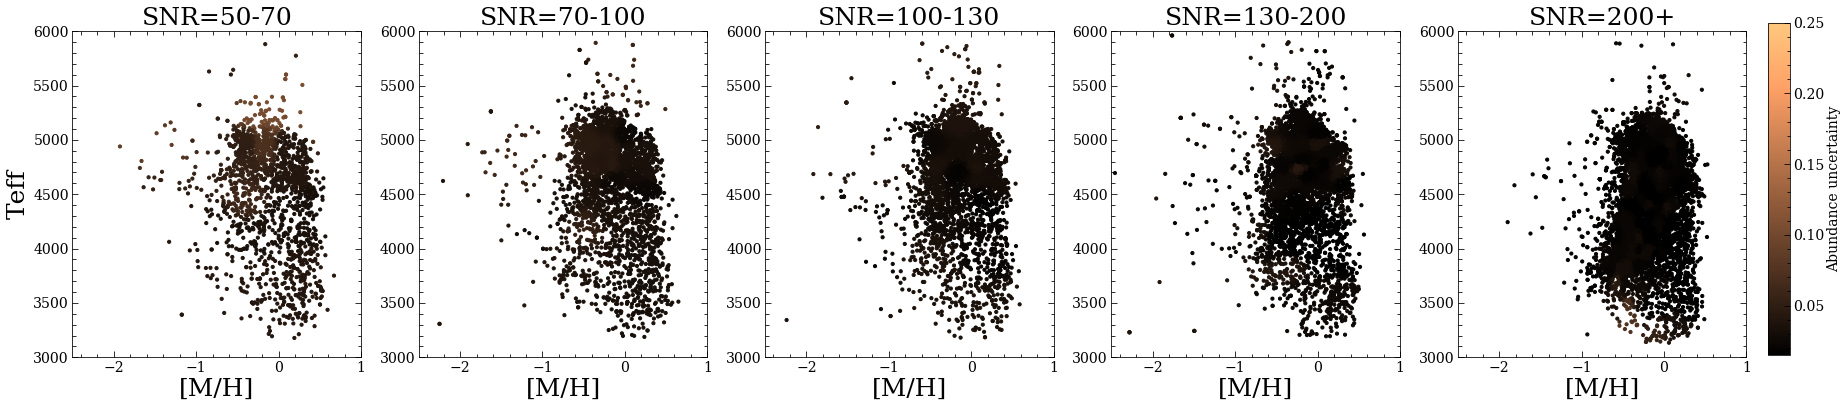

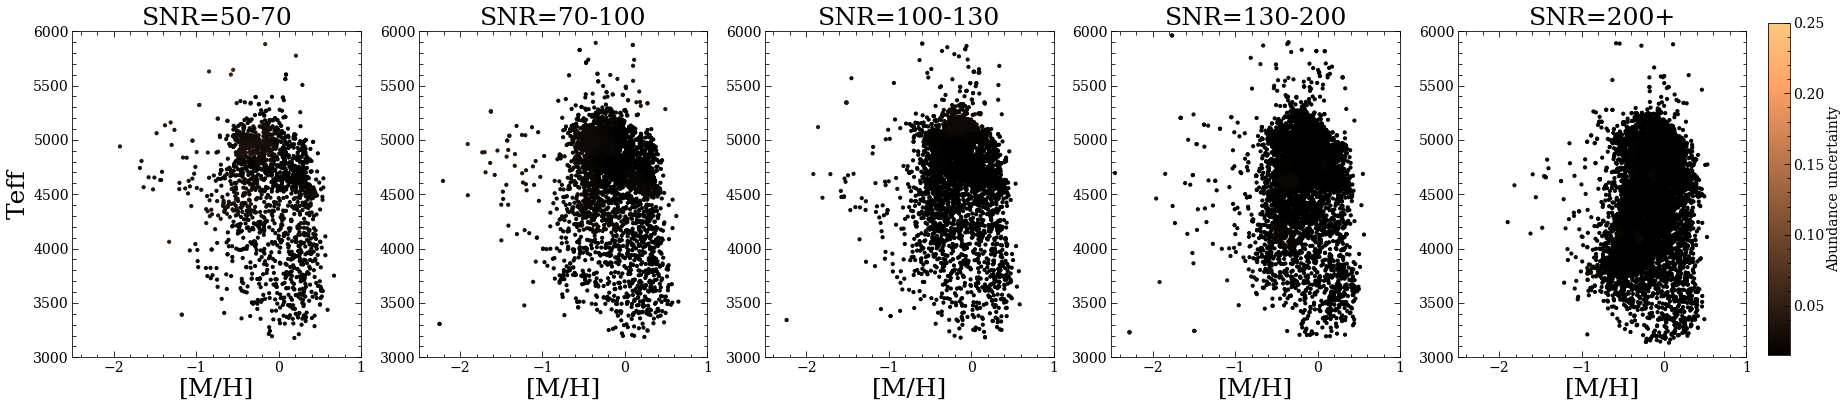

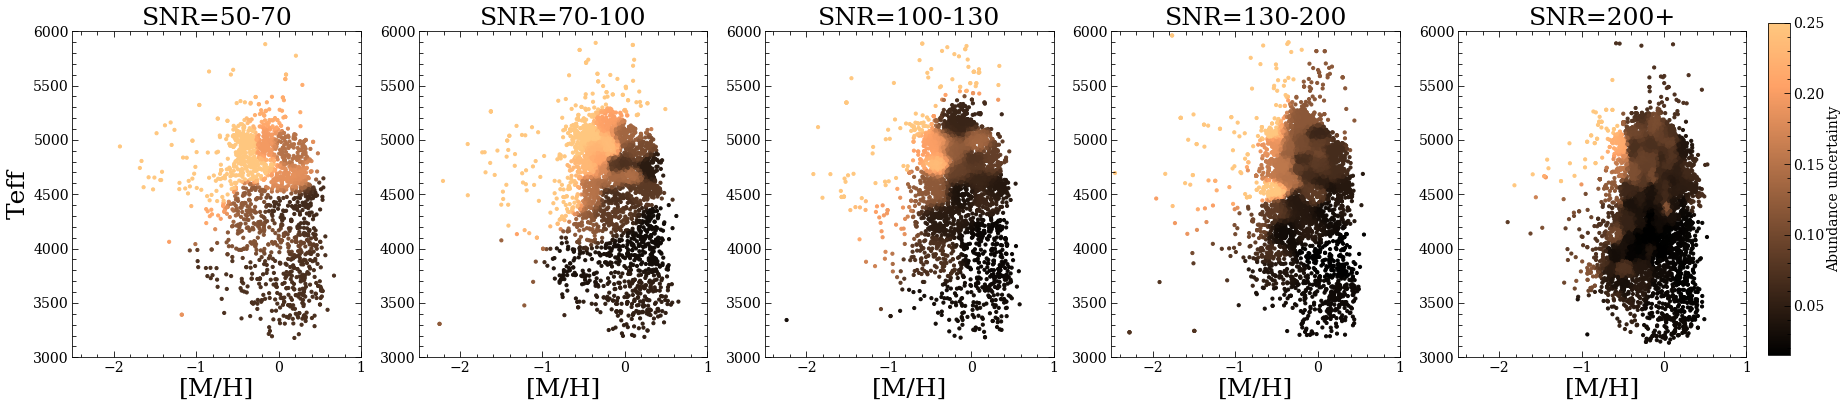

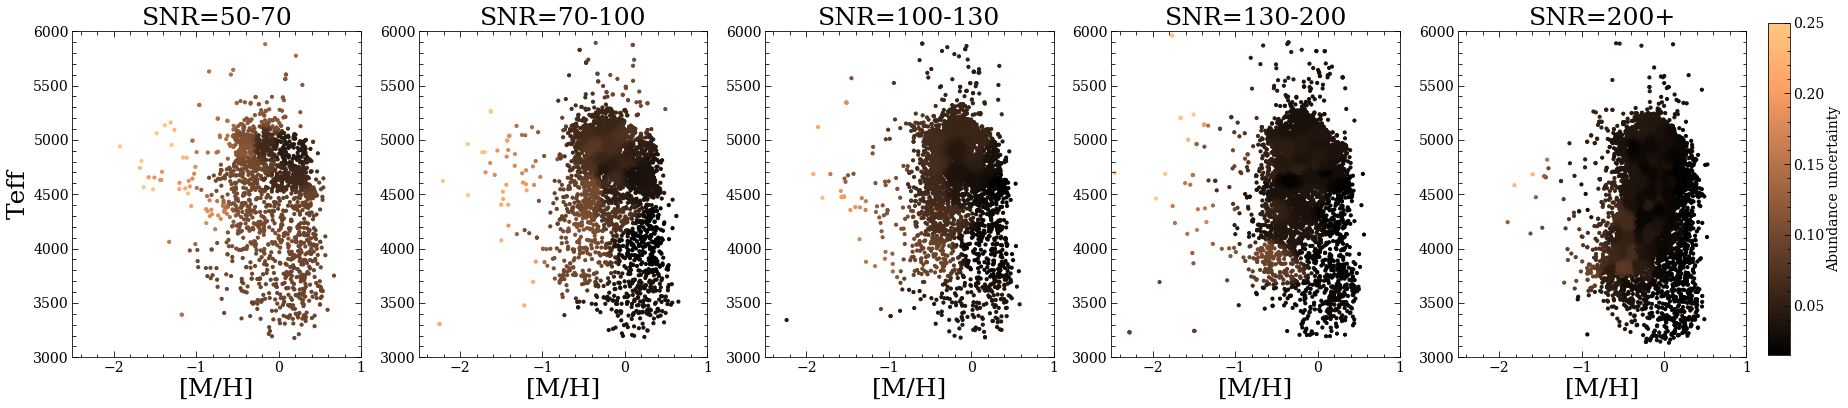

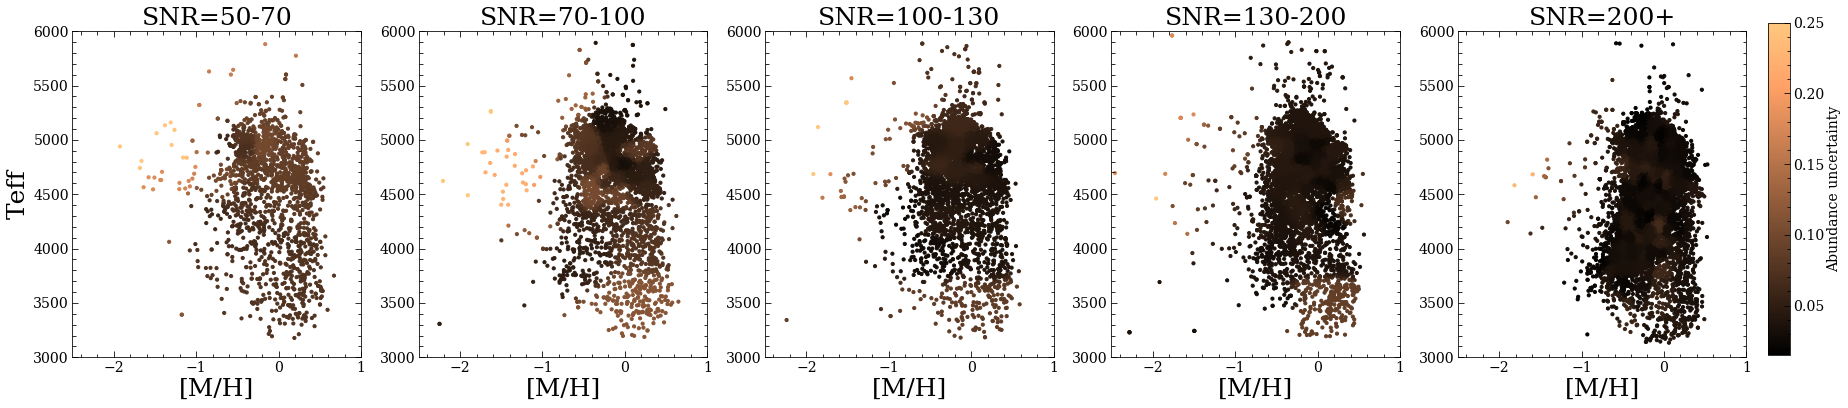

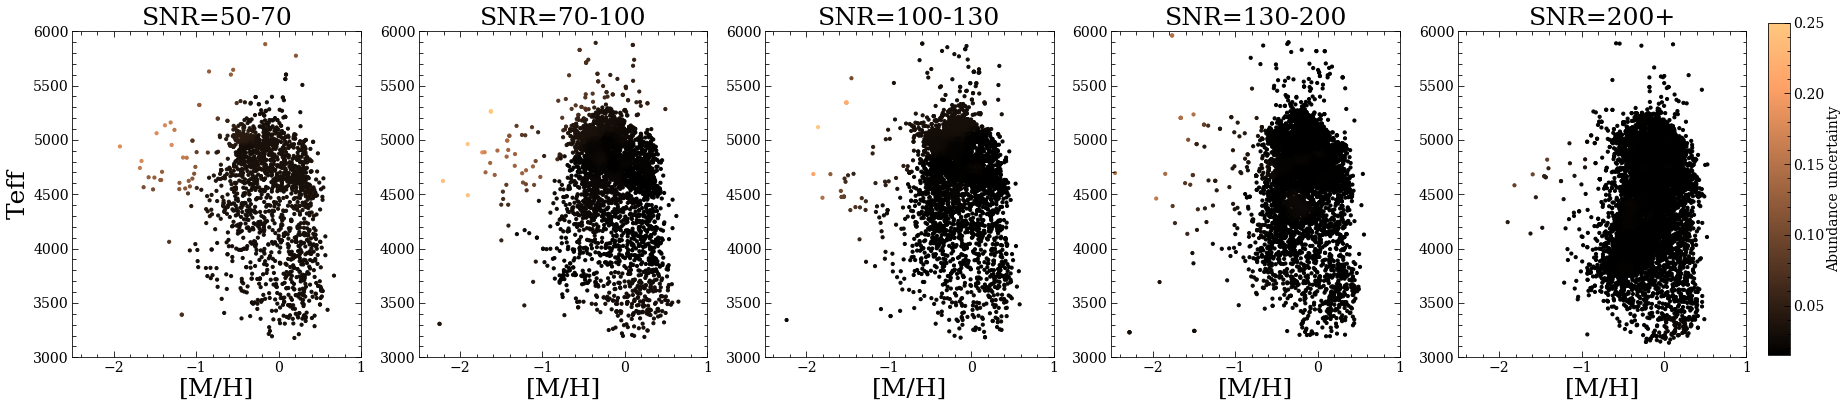

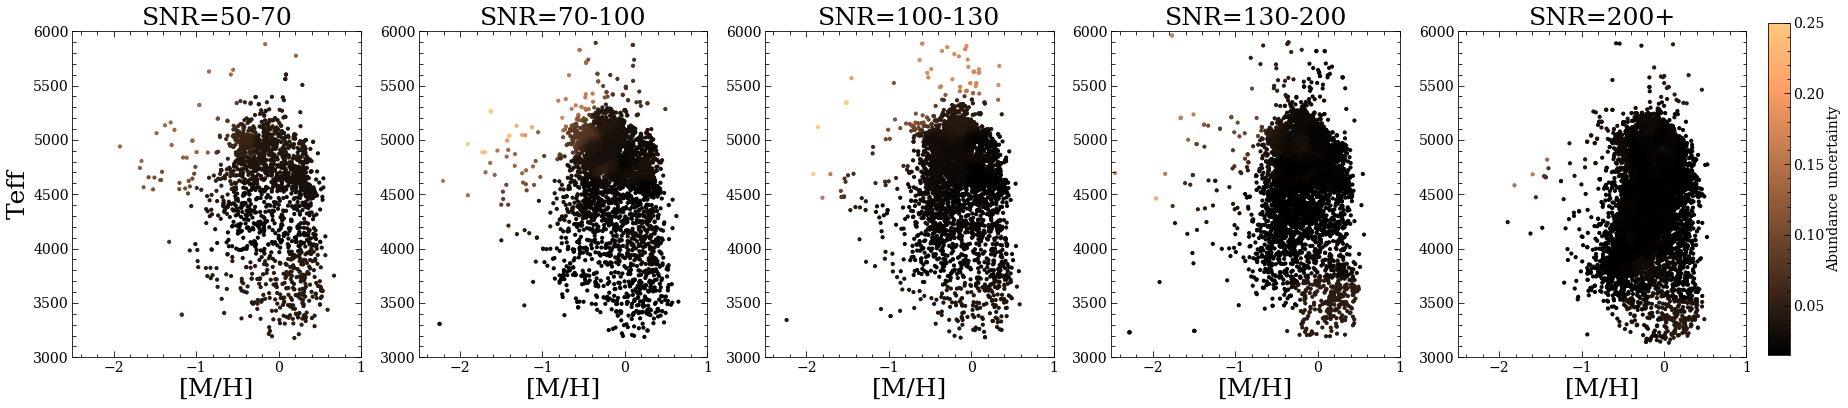

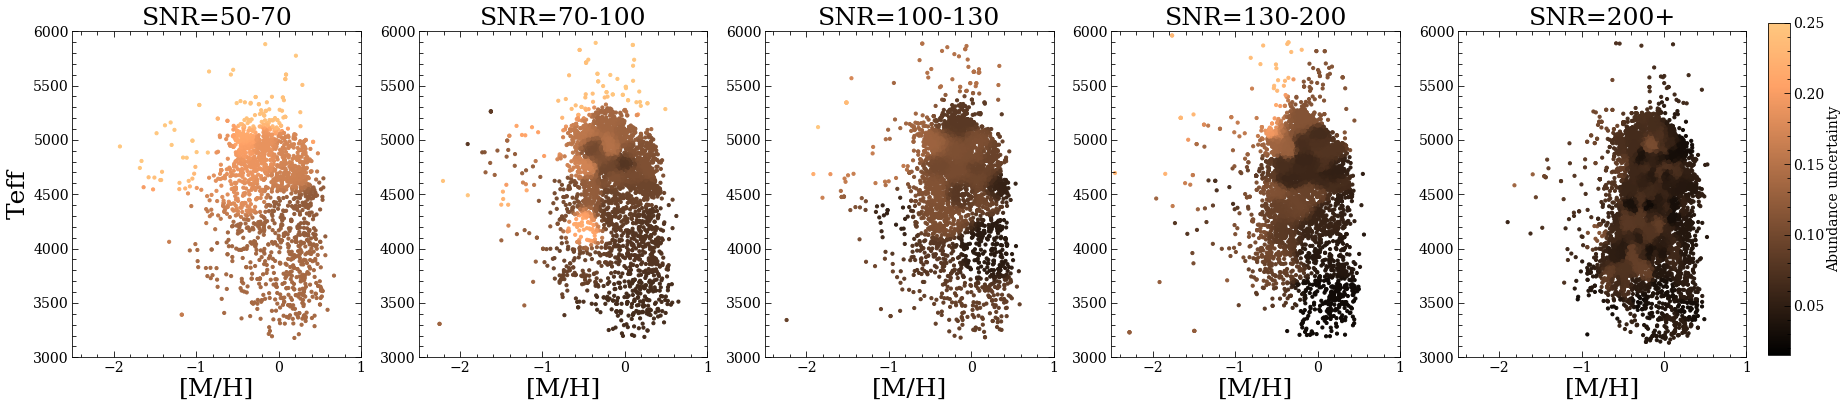

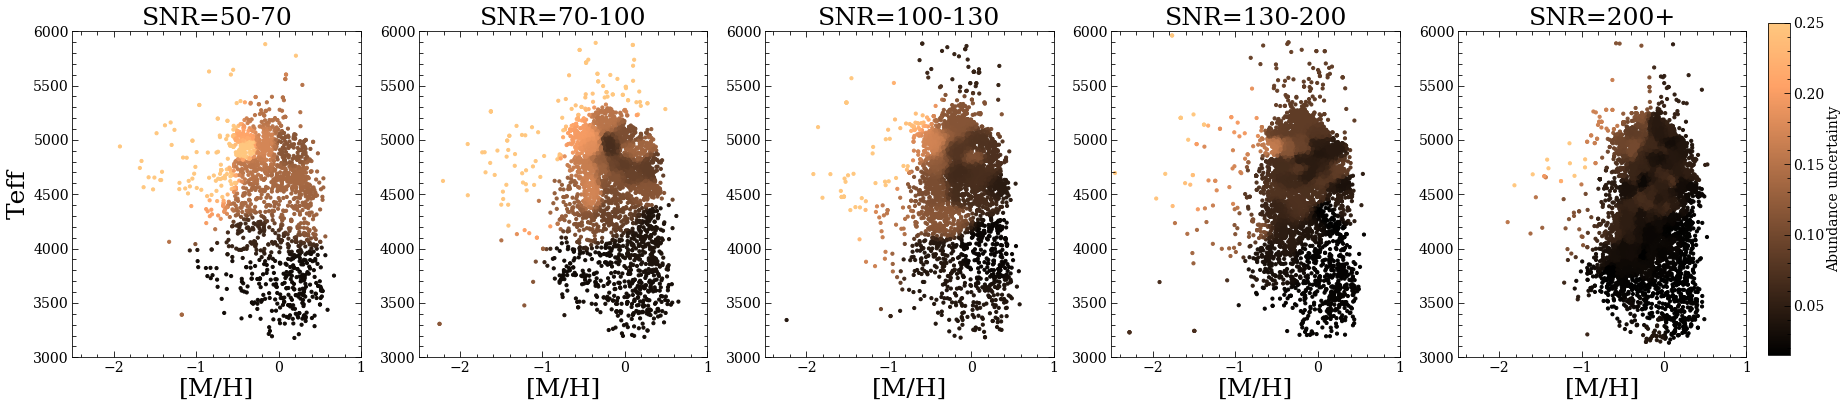

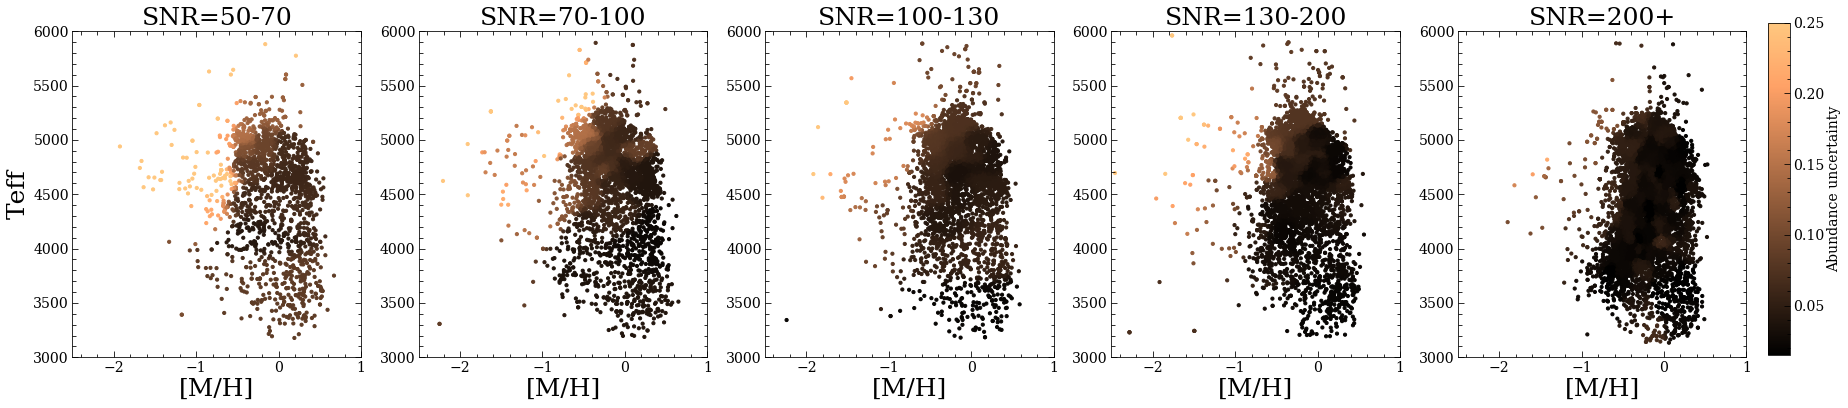

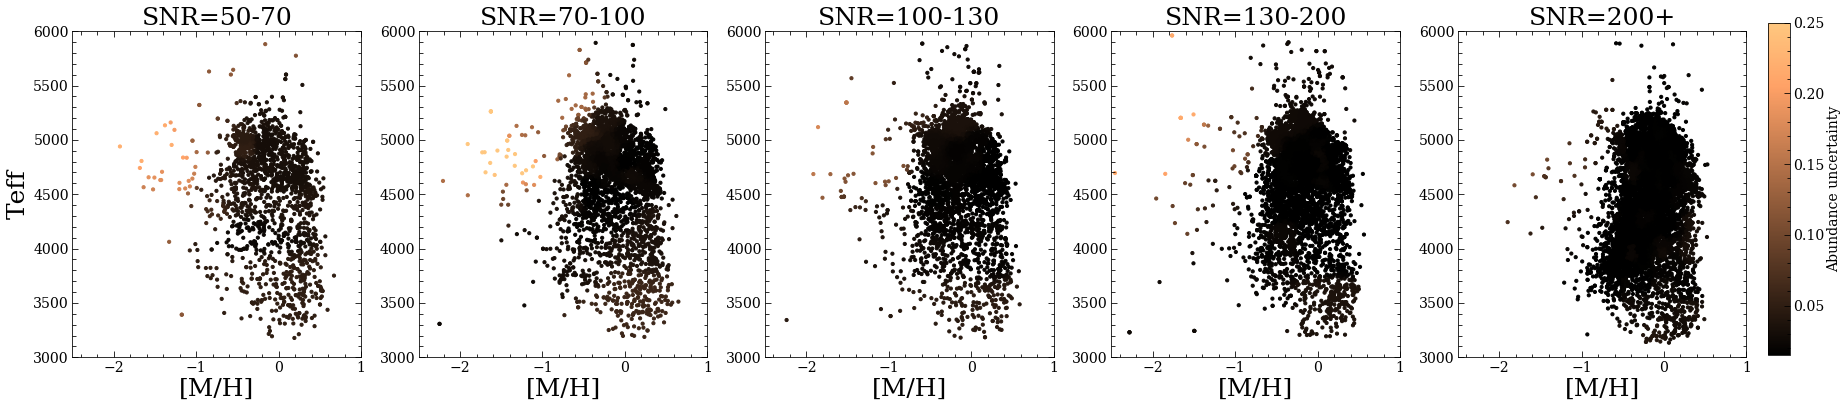

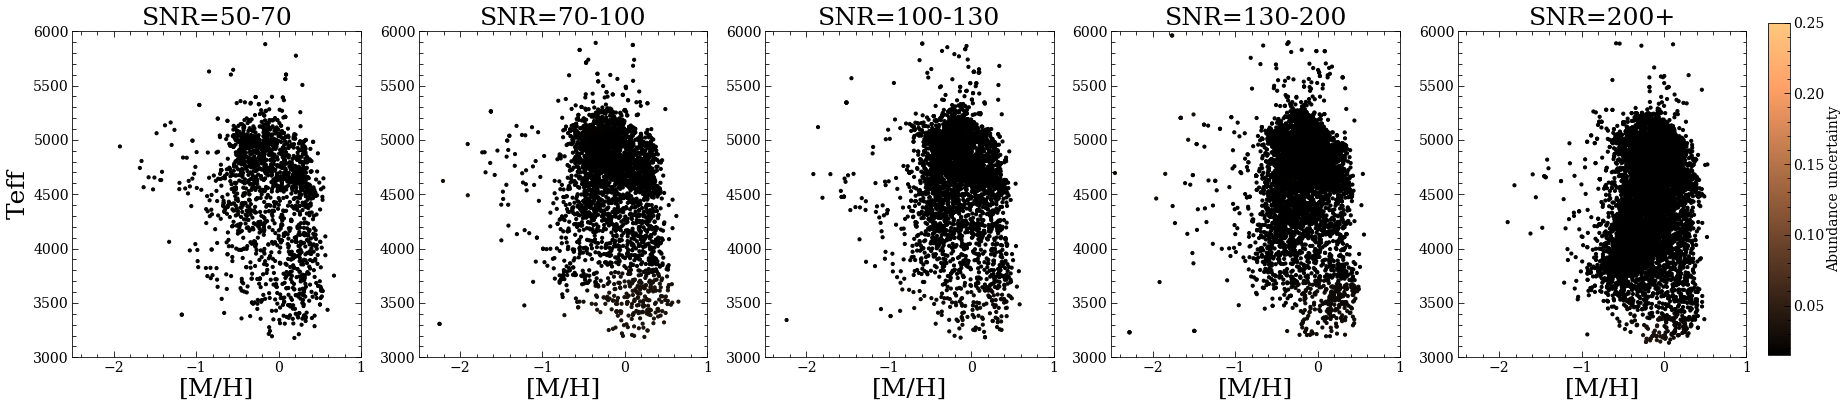

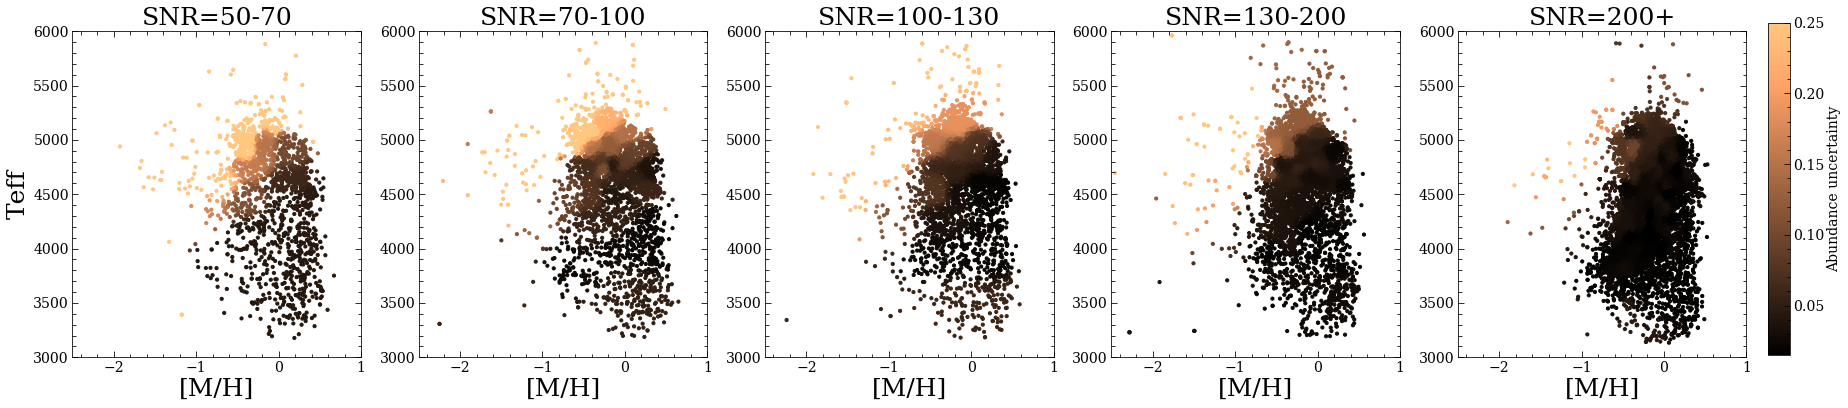

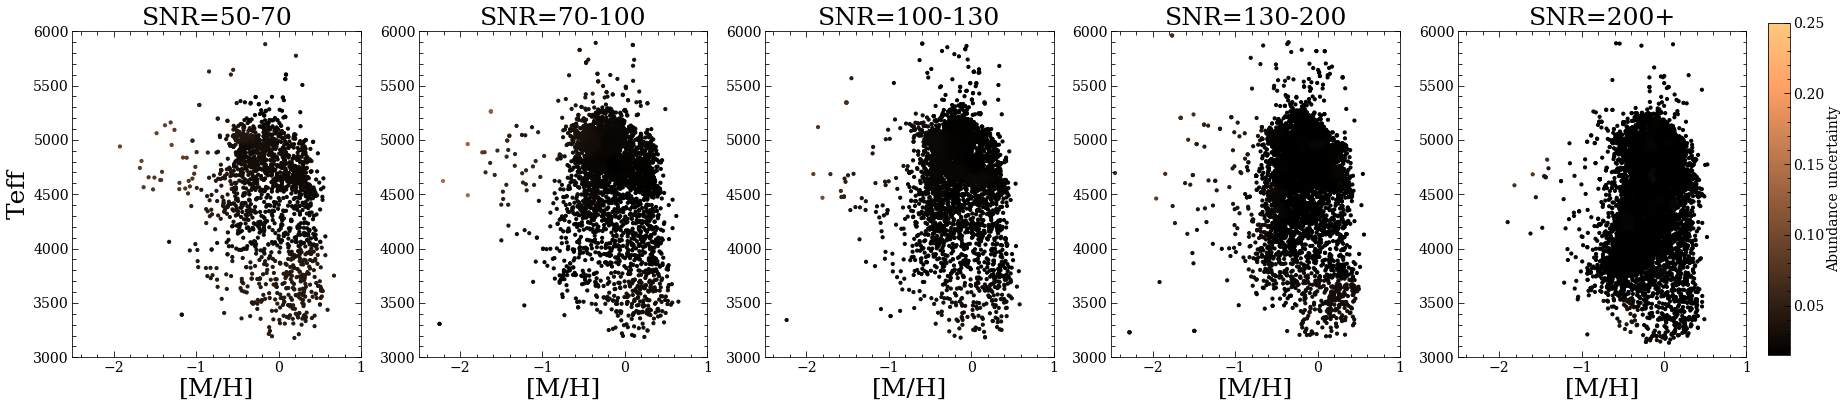

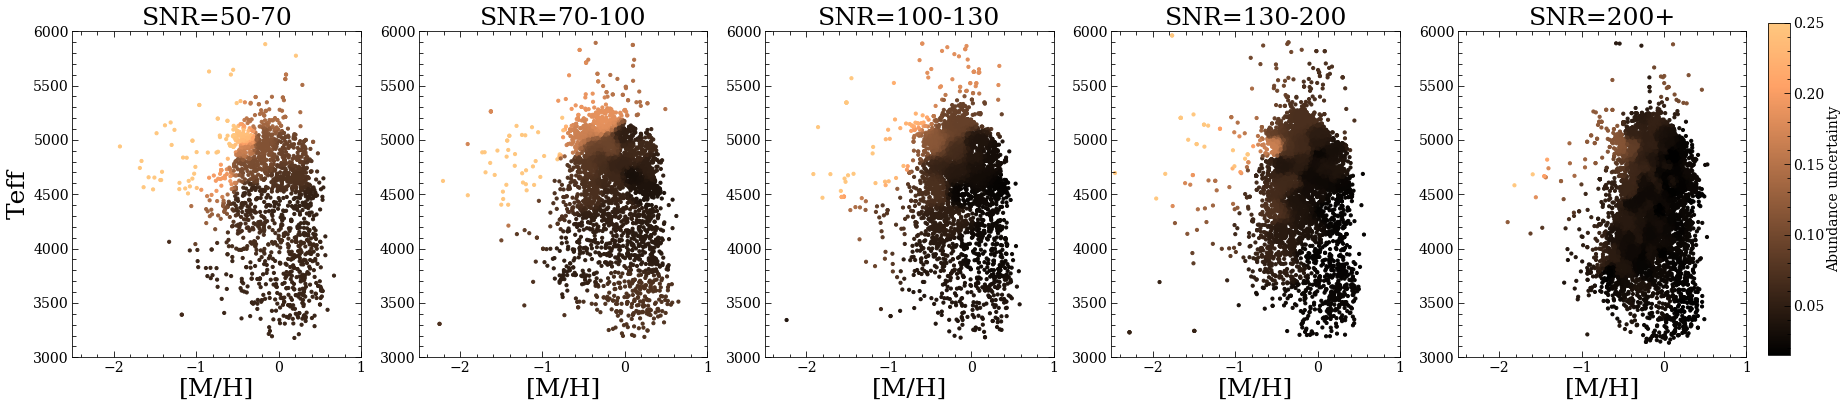

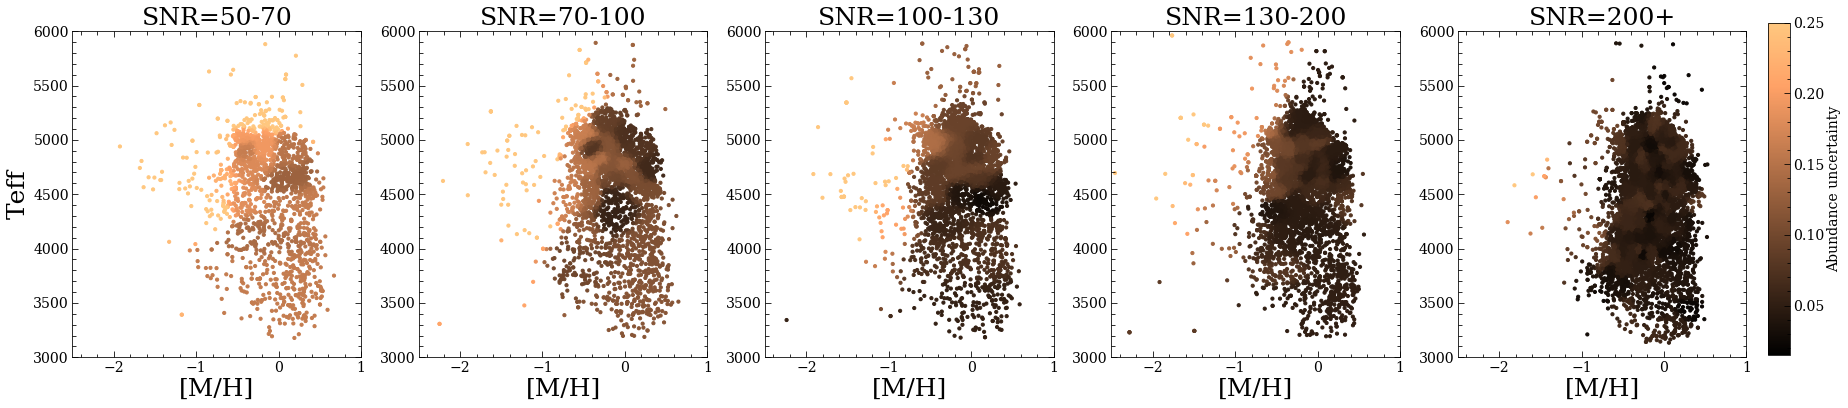

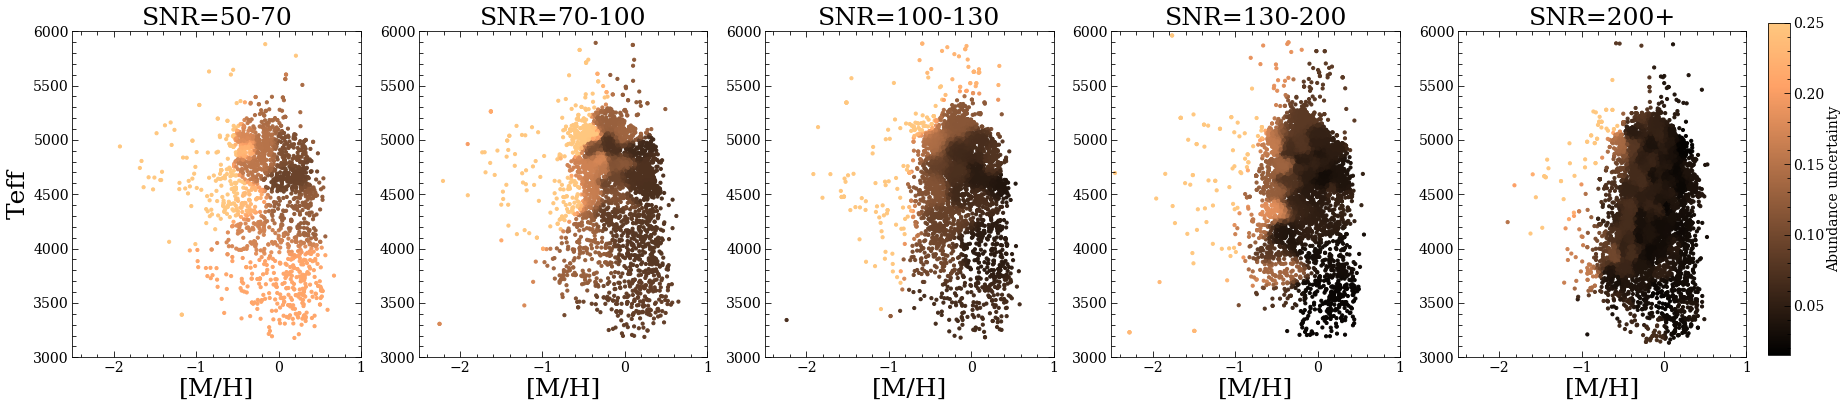

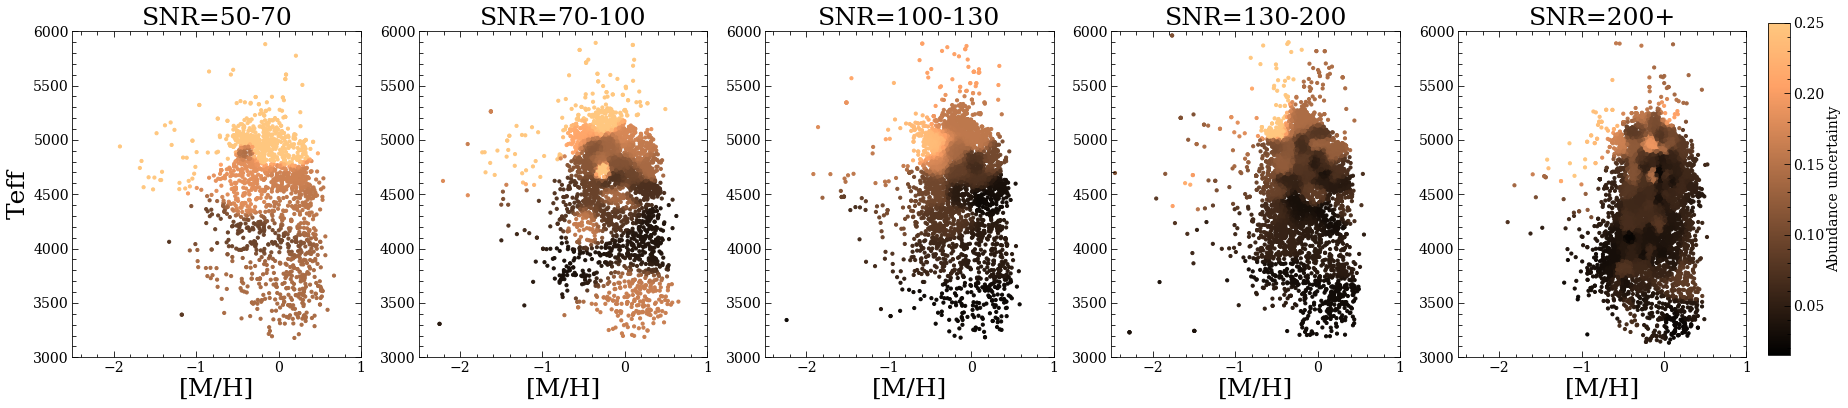

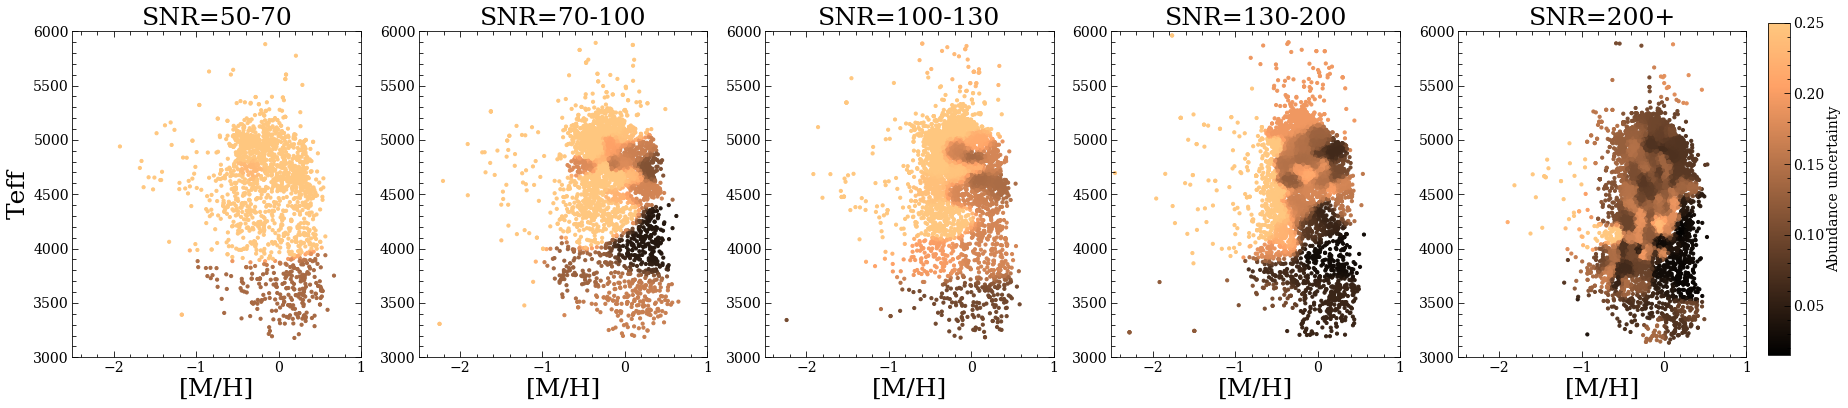

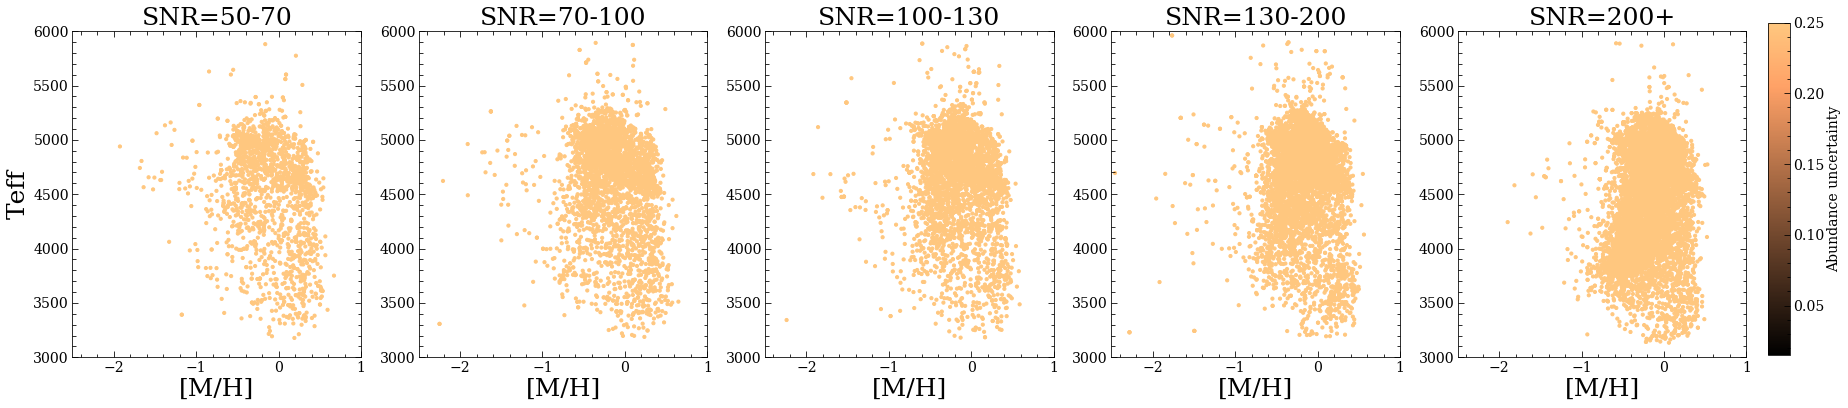

In [24]:
#plot the newly derived uncertainties according the bins
conditions_snr=[np.logical_and(diffs_df_new['SNR']>50,diffs_df_new['SNR']<70),\
                np.logical_and(diffs_df_new['SNR']>70,diffs_df_new['SNR']<100),\
            np.logical_and(diffs_df_new['SNR']>100,diffs_df_new['SNR']<130),\
            np.logical_and(diffs_df_new['SNR']>130,diffs_df_new['SNR']<200),\
            diffs_df_new['SNR']>200]
condition_nan=[~np.isnan(diffs_df_new['MG_FE_diff'])]
condition_nan=np.array(condition_nan).reshape(-1)
snr=['50-70','70-100','100-130','130-200','200+']

for i in range(len(elements)):
    fig,ax=plt.subplots(nrows=1,ncols=len(conditions_snr),figsize=(30,len(conditions_snr)+1))
    for j in range(len(conditions_snr)):
        condition=[cluster_members.data['SNR_bin']==j]
        im=ax[j].scatter(cluster_members.data['M_H'][condition],cluster_members.data['TEFF'][condition],s=10,\
                         c=cluster_members.data[elements[i]+'_uncertainty_derived'][condition],\
                         edgecolor='face',vmin=0.015,vmax=0.25, cmap = 'copper')# ax[0].set_xticks([-1.0,-0.5,0.0,0.5])
        ax[j].set_xlabel('[M/H]', fontsize = 25)
        ax[0].set_ylabel('Teff', fontsize = 25)
        ax[j].set_title('SNR='+str(snr[j]), fontsize = 25)
        ax[j].set_ylim([3000,6000])
        ax[j].set_xlim([-2.5,1.0])
    cbar_ax = plt.gcf().add_axes([0.91, 0.13, 0.01, 0.77])
    plt.colorbar(im,cax=cbar_ax, label = 'Abundance uncertainty')
#     fig.text(0.5,0.0,'[M/H]')
#     fig.suptitle('['+elements[i]+'] Uncertainties in VORONOI bins of [M/H], Teff and SNR'
#                  '(GIANTS)',x=0.5,y=1.05,fontsize=13)
#     plt.savefig('Run_8_Uncertainties/5 SNR bins/'+elements[i]+
#                 '_uncertainties_for__in_VORONOI_bins_of_M_H_Teff_and_SNR_giants_'
#                 'median_run_8.png',dpi=300,bbox_inches='tight')
    plt.show()


In [26]:
#save the merged file which contains the newly redived uncertainties for all the potential cluster members
cluster_members.data.write('Cluster_members_rederived_uncertainties',\
                           format='fits',overwrite=False)

In [29]:
# cluster_members.data=Table.read('Cluster_members_rederived_uncertainties')